# Credit Card Fraud Detection — Unsupervised Anomaly Detection

This notebook compares three unsupervised anomaly detection algorithms for identifying fraudulent credit card transactions:

- **Isolation Forest** — ensemble method that isolates anomalies via random feature partitioning
- **Local Outlier Factor (LOF)** — density-based method comparing local density to nearest neighbors
- **One-Class SVM** — learns a hypersphere boundary around "normal" data

**Dataset**: [MLG-ULB Credit Card Fraud](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) — 284,807 transactions, only **492 (0.17%)** fraudulent.

In [1]:
import kagglehub 
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:",path)

/Users/abozein/Desktop/Anomaly Detection/testenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/abozein/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


## 1. Data Loading

The dataset is downloaded automatically via `kagglehub`. Alternatively, place `creditcard.csv` manually in the project root.

In [2]:
import pandas as pd 
df = pd.read_csv("creditcard.csv")

## 2. Exploratory Data Analysis

Inspect the dataset shape, data types, missing values, and class distribution.

In [3]:
df.shape

(284807, 31)

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

The dataset is **heavily imbalanced**: only 0.17% of transactions are fraudulent. This makes supervised approaches difficult without resampling and motivates the use of unsupervised anomaly detection.

## 3. Data Preprocessing

We apply `StandardScaler` to normalize all 30 features (excluding `Class`), then reduce to 2 dimensions with **PCA** for visualization.

> **Note:** V1–V28 are already PCA-transformed by the dataset provider for privacy. This is a second-level PCA used purely for 2D plotting.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 

X_scaled = scaler.fit_transform(df.drop(columns=['Class']))

In [9]:
X_scaled.shape

(284807, 30)

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

X_pca.shape

(284807, 2)

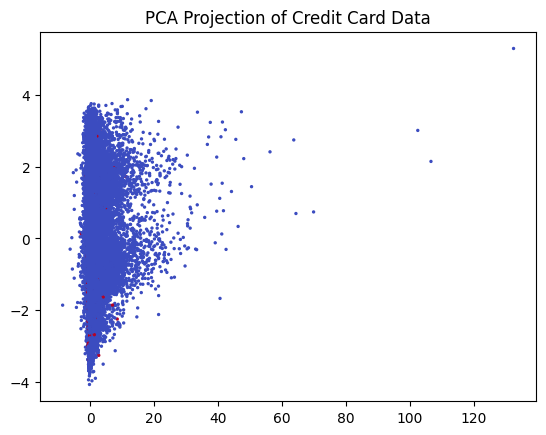

In [11]:
import matplotlib.pyplot as plt 
plt.scatter(X_pca[:,0], X_pca[:, 1], c=df['Class'], cmap='coolwarm', s=2)
plt.title('PCA Projection of Credit Card Data')
plt.show()

Fraudulent transactions (red) occupy a slightly different region in PCA space but largely overlap with normal ones — confirming this is a challenging detection problem.

---

## 4. Anomaly Detection Models

All models are configured with `contamination=0.0017` (~0.17%), matching the true fraud rate in the dataset (492 / 284,807).

### 4.1 Isolation Forest

Isolation Forest builds an ensemble of random decision trees. Anomalies are isolated with **fewer splits** and sit closer to the tree root. It is fast, scales well to large datasets, and handles high-dimensional data effectively.

In [12]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators= 100,
    contamination= 0.0017,
    random_state=42
)

y_pred_iso = iso.fit_predict(X_scaled)

In [13]:
df['iso_pred'] = (y_pred_iso == -1).astype(int)

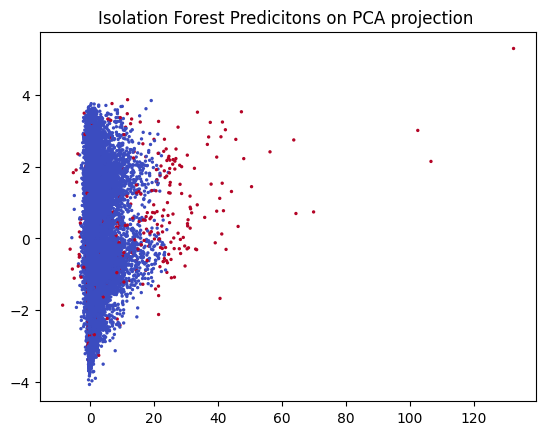

In [14]:
plt.scatter(X_pca[:,0] , X_pca[:,1], c=df['iso_pred'], cmap="coolwarm", s=2)
plt.title("Isolation Forest Predicitons on PCA projection ")
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(df['Class'],df['iso_pred']))
print(classification_report(df['Class'],df['iso_pred']))

[[283955    360]
 [   367    125]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.26      0.25      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807



Isolation Forest correctly identifies **125 / 492 frauds (recall = 25%)** with 360 false positives.

---

### 4.2 Local Outlier Factor (LOF)

LOF compares the local density of each sample to its `n_neighbors` nearest neighbors. Points with significantly lower density than their neighbors are flagged as outliers. Effective on small-to-medium datasets but known to struggle at large scale.

In [16]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.0017
)

y_pred_lof = lof.fit_predict(X_scaled)
df["lof_pred"] = (y_pred_lof == -1).astype(int)

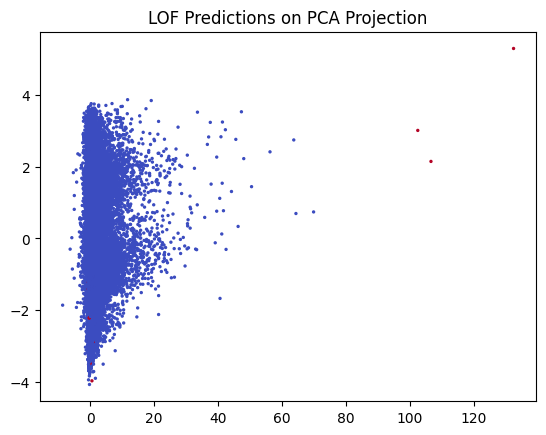

In [17]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["lof_pred"], cmap="coolwarm", s=2)
plt.title("LOF Predictions on PCA Projection")
plt.show()

In [18]:
print(confusion_matrix(df["Class"], df["lof_pred"]))
print(classification_report(df["Class"], df["lof_pred"]))

[[283830    485]
 [   492      0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.00      0.00      0.00       492

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807



**LOF fails entirely (recall = 0%).** It flags 485 normal transactions as anomalies while missing all 492 actual frauds.

This is a known limitation: LOF relies on local density estimation in the original feature space. At ~285K samples × 30 features, local density contrasts between fraudulent and normal transactions effectively disappear — every point's neighborhood looks equally dense, so LOF cannot distinguish outliers from inliers.

---

### 4.3 One-Class SVM

One-Class SVM fits a hypersphere boundary around "normal" data in a kernel-transformed space. Points outside the boundary are flagged as anomalous. The `nu` parameter (set equal to `contamination`) controls the fraction of training points allowed outside the boundary.

In [19]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM(
    kernel="rbf",
    nu=0.0017,  # similar to contamination
    gamma="auto"
)

y_pred_svm = svm.fit_predict(X_scaled)
df["svm_pred"] = (y_pred_svm == -1).astype(int)

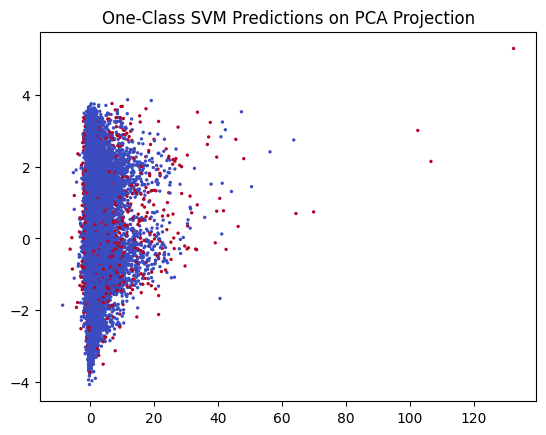

In [20]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["svm_pred"], cmap="coolwarm", s=2)
plt.title("One-Class SVM Predictions on PCA Projection")
plt.show()

In [21]:
print(confusion_matrix(df["Class"], df["svm_pred"]))
print(classification_report(df["Class"], df["svm_pred"]))

[[282955   1360]
 [   369    123]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.08      0.25      0.12       492

    accuracy                           0.99    284807
   macro avg       0.54      0.62      0.56    284807
weighted avg       1.00      0.99      1.00    284807



One-Class SVM identifies **123 / 492 frauds (recall = 25%)** but produces significantly more false positives than Isolation Forest (1,360 vs. 360). It is also the slowest algorithm due to its quadratic scaling with dataset size.

---

## 5. Model Comparison

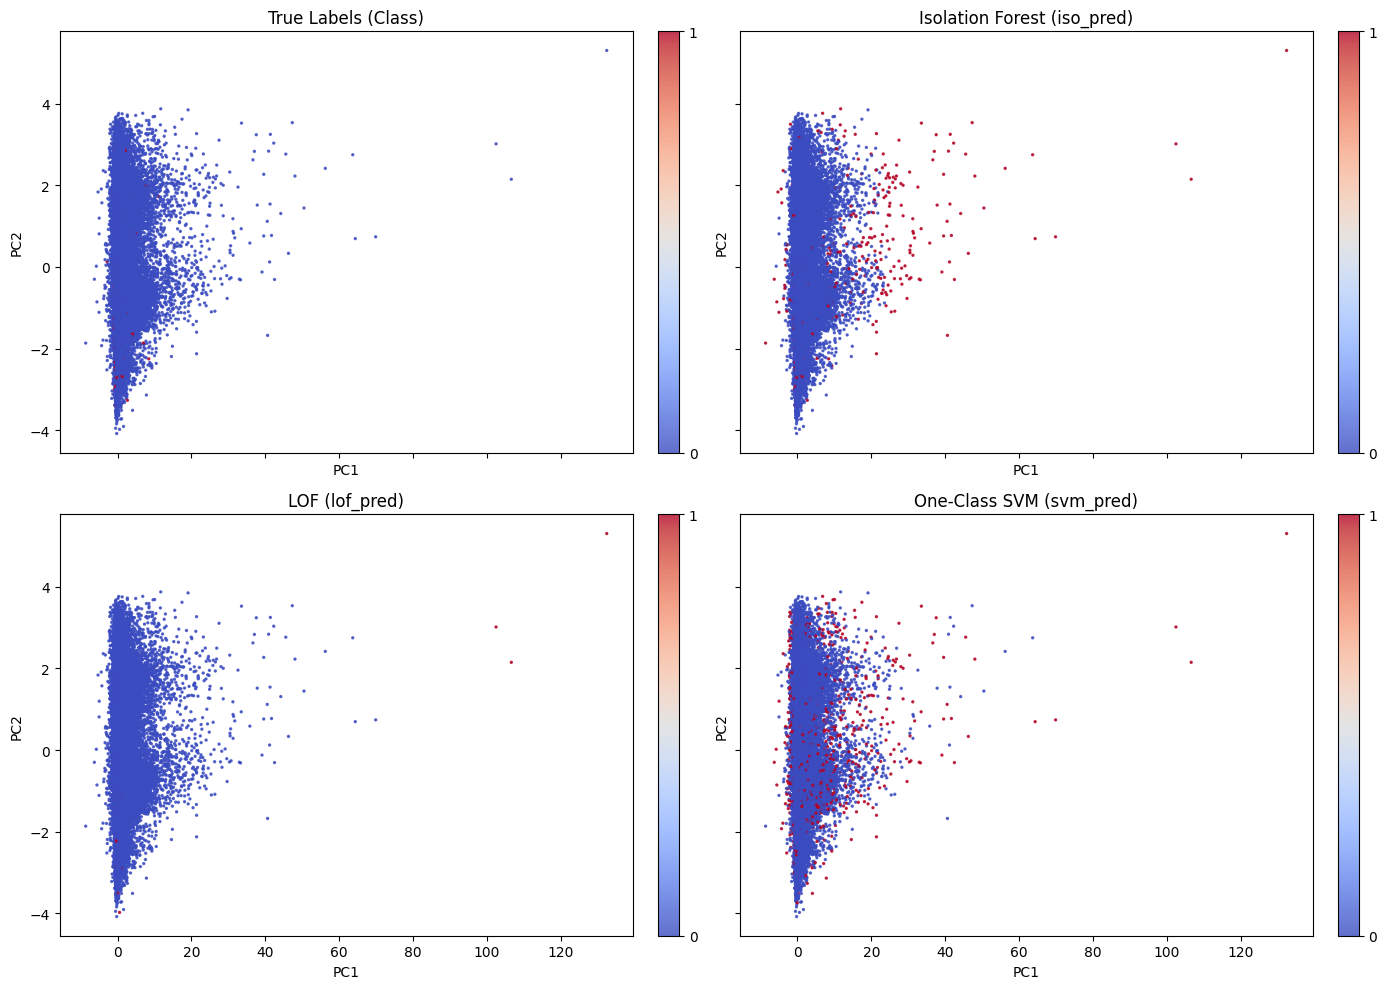

In [22]:
import matplotlib.pyplot as plt

# Uses:
# X_pca (n_samples, 2)
# df["Class"], df["iso_pred"], df["lof_pred"], df["svm_pred"]

titles_and_cols = [
    ("True Labels (Class)", "Class"),
    ("Isolation Forest (iso_pred)", "iso_pred"),
    ("LOF (lof_pred)", "lof_pred"),
    ("One-Class SVM (svm_pred)", "svm_pred"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (title, col) in zip(axes, titles_and_cols):
    sc = ax.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=df[col].values,   # important: ensure it's an array
        s=2,
        cmap="coolwarm",
        alpha=0.8
    )
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["0", "1"])

plt.tight_layout()
plt.show()

In [23]:
import pandas as pd

summary = pd.DataFrame({
    'Model':            ['Isolation Forest', 'Local Outlier Factor', 'One-Class SVM'],
    'True Positives':   [125,    0,    123],
    'False Positives':  [360,  485,  1360],
    'False Negatives':  [367,  492,   369],
    'True Negatives':   [283955, 283830, 282955],
    'Precision':        [0.26,  0.00,  0.08],
    'Recall':           [0.25,  0.00,  0.25],
    'F1-Score':         [0.26,  0.00,  0.12],
})

summary.set_index('Model', inplace=True)
summary.style.highlight_max(subset=['Precision', 'Recall', 'F1-Score'], color='lightgreen')

AttributeError: The '.style' accessor requires jinja2

## Conclusions

| | Isolation Forest | LOF | One-Class SVM |
|---|---|---|---|
| Recall (Fraud) | **25%** | 0% | 25% |
| False Positives | **360** | 485 | 1,360 |
| F1-Score | **0.26** | 0.00 | 0.12 |
| Scalability | Fast | Slow | Very Slow |

**Isolation Forest** is the best model for this problem — highest F1, fewest false positives, and fastest to train.

### Why did LOF fail?
LOF relies on local density estimation. At 285K high-dimensional samples, every point's neighborhood looks equally dense — the contrast LOF needs to detect outliers disappears. This is a well-documented limitation for large-scale datasets.

### Recommendations for further improvement
- **Tune `contamination`**: Use a held-out validation set to optimize the threshold
- **Try supervised methods**: XGBoost or LightGBM with SMOTE oversampling for significantly higher recall
- **Ensemble anomaly detectors**: Average scores from Isolation Forest + SVM for a better precision-recall trade-off
- **Feature importance**: Analyze which V-features drive fraud detection (V14, V4, V11 are known to be most informative in this dataset)